[Go to this directory index](./)

Contents
  - [More optimization trials¶](#More-optimization-trials)
      - [Trial 2.1¶](#Trial-2.1)
      - [Trial 2.2¶](#Trial-2.2)
        - [Aside¶](#Aside)
      - [Trial 2.3¶](#Trial-2.3)

<IPython.core.display.Javascript object>

# More optimization trials

Previously, I tried throwing a bunch of optimizers at my model. I liked the results from the scipy.optimize routines COBYLA and BFGS. Let's try adjusting how we handle the constraints, and see if we get better results.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import numpy
from IPython.display import HTML, SVG

In [3]:
matplotlib.use('svg')
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.sans-serif'] = 'Arial'

In [4]:
from io import BytesIO
def pltsvg():
    imgdata = BytesIO()
    plt.savefig(imgdata)
    imgdata.seek(0)
    display(SVG(data=imgdata.read()))

### Trial 2.1

In general, here is how we compute the modified objective function. GenOpt manual suggests adding functions to the objective, namely separate barrier (B) and penalty (P) functions. The objective function is, with step number as $k$,

$$ Objective = -Q_{cooling}(x) + \mu_1 B(x) + \mu_2 P(x) $$

$$ \mu_1 = k^{-2}$$
$$ B(x) = \left(\sum_{j=1}^{N_B} g_j(x) \right) ^ {-1} $$

$$\mu_2 = k^{2}$$
$$ P(x) = \sum_{j=N_B+1}^{N_B + N_P} g_j(x)$$

GenOpt implements a mechanism to pass in the step number. However, using the scipy.optimize routines, passing in the step number is a challenge, so the `Problem` object should probably use its own counter of function calls. This could be quirky, since then the objective function is changing with each call. Some routines allow for termination after a number of steps, so we could run a while, increment step number, then continue.

But we need to make some decisions.

- Which constraints should be handled by barriers, and which by penalties?
  - Use barriers for hard constraints, eg. required for feasibility of the chiller model
  - Use penalties for soft constraints, eg. heat exchange feasibility that can be violated now and satisfied later
- With scipy.optimize, we can directly apply constraints on the input variables (such as $T_1 > T_2$)



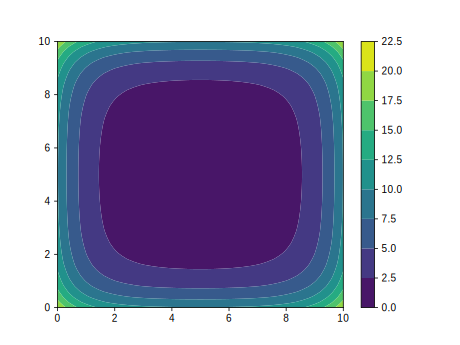

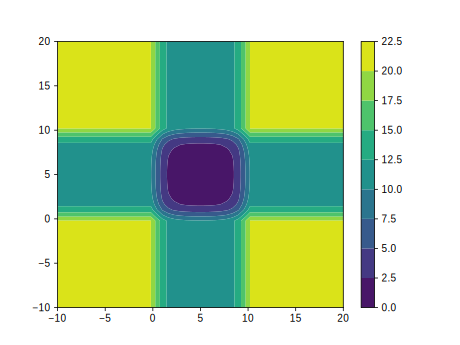

In [231]:
# Demo barriers
xx = numpy.linspace(0,10)
yy = numpy.linspace(0,10)
X, Y = numpy.meshgrid(xx,yy)
B = numpy.zeros_like(X)
mu_B = 10
for i, (xi,yi) in enumerate(zip(X.flat,Y.flat)):
    c = numpy.array([xi, yi, (10-xi), (10-yi)])
    g = numpy.negative(c)
    # The length scale for the barrier
    dx = 1
    b = numpy.exp(g / dx)
    B.flat[i] = mu_B * numpy.sum(b)
plt.close('all')
plt.contourf(X,Y,B)
plt.colorbar()
pltsvg()

xx = numpy.linspace(-10,20)
yy = numpy.linspace(-10,20)
X, Y = numpy.meshgrid(xx,yy)
P = numpy.zeros_like(X)

for i, (xi,yi) in enumerate(zip(X.flat,Y.flat)):
    c = numpy.array([xi, yi, (10-xi), (10-yi)])
    g = numpy.negative(c)
    g = saturate(g)
    # The length scale for the penalty
    dx = 1
    b = numpy.exp(g / dx)
    mu = 10
    P.flat[i] = mu * numpy.sum(b)
plt.close('all')
plt.contourf(X,Y,P)
plt.colorbar()
pltsvg()


In [196]:
X.flat[5]=0
X

array([[ 0.        ,  0.02040816,  0.04081633, ...,  0.95918367,
         0.97959184,  1.        ],
       [ 0.        ,  0.02040816,  0.04081633, ...,  0.95918367,
         0.97959184,  1.        ],
       [ 0.        ,  0.02040816,  0.04081633, ...,  0.95918367,
         0.97959184,  1.        ],
       ..., 
       [ 0.        ,  0.02040816,  0.04081633, ...,  0.95918367,
         0.97959184,  1.        ],
       [ 0.        ,  0.02040816,  0.04081633, ...,  0.95918367,
         0.97959184,  1.        ],
       [ 0.        ,  0.02040816,  0.04081633, ...,  0.95918367,
         0.97959184,  1.        ]])

In [146]:
import ammonia1
import system_aqua1
import scipy.optimize

def saturate(x, bottom=-numpy.inf, top=0):
    a_bottom = numpy.empty_like(x)
    a_top = numpy.empty_like(x)
    a_bottom.fill(bottom)
    a_top.fill(top)
    return numpy.minimum(a_top,
                         numpy.maximum(a_bottom,
                                       x))

class Problem_2_1:
    def __init__(self, bdry, UAgoal, mu=0.1):
        self.bdry = bdry
        self.UAgoal = UAgoal
        self.mu = mu
        self.Ncons = 7
        self.n_calls = 0
        # Soft constraints mode: this is sent to minimizer
        self.constraints = [{'type': 'ineq',
                             'fun': self.constraint,
                             'args': (i,)
                            } for i in range(self.Ncons)]
            
    def objective(self, xC):
        step_number = numpy.floor(self.n_calls / 7)
        self.n_calls += 1
        print(xC,flush=True)
        Q,B,P = 0.,0.,0.
        try:
            ch = system_aqua1.makeChiller(xC)
            sys = system_aqua1.System(self.bdry, ch)
            
            # Barriers
            # Magnitude tends to zero, slowly
            mu_B = 100. * numpy.exp(-0.01 * step_number)
            
            # These are zero at the boundary ...
            barriers = [-ch.check_rectifier_delta_T] \
                       + [-deltaT
                          for name, deltaT, epsilon, UA, Qhx in sys.data]
            barriers = saturate(barriers)
            # Map them to be -1 at boundary and tending to zero away from it ...
            barriers = -numpy.exp(barriers)
            B = mu_B / numpy.sum(barriers)
            
            # Penalties
            # Magnitude tends to infinite, bit more quickly
            mu_P = 0.01 * numpy.exp(0.01 * step_number)
            penalties = [-(1.0 - sys.totalUA/self.UAgoal)]
            penalties = saturate(penalties, bottom=-self.UAgoal, top=0)
            P = mu_P * numpy.sum(penalties ** 2)
            
            Q = sys.chiller.Q_evap
        except:
            Q = numpy.inf
        
        print(self.n_calls, step_number, Q, B, P, "\n", flush=True)
        return -Q + B + P
    
    def constraint(self, x, *args):
        cons = [x[0] - 0.1,
                1. - x[0],
                x[2] - x[1] - 1.0,
                x[3] - x[2] - 1.0,
                x[4] - x[1] - 10.0,
                x[5] - x[3] - 1.0,
                x[5] - x[4] - 1.0]
        if len(args) > 0:
            i, = args
            return cons[i]
        else:
            return cons

    def callback(self, x):
        print("Did an iteration at ", x)

In [147]:
T_heat_reject = 305.
UAgoal = 100
xB = [400, 1, T_heat_reject, 3, T_heat_reject, 5, 285, 4, T_heat_reject, 0.15]
bdry = system_aqua1.makeBoundary(xB)
P = Problem_2_1(bdry, UAgoal)

In [148]:
x = numpy.array([0.51284472, 277.97717012, 312.16427764, 313.6952877,
               310.24856734, 374.14020482])

In [149]:
P.n_calls = 7 * numpy.floor(P.n_calls / 7)
opt = scipy.optimize.minimize(P.objective, x, method="COBYLA",
                              constraints=P.constraints, callback=P.callback,
                              options={'disp':True,'maxiter':100,'rhobeg':0.1})
opt

[   0.51284472  277.97717012  312.16427764  313.6952877   310.24856734
  374.14020482]


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\optimize\_minimize.py:403: RuntimeWarning: Method COBYLA does not support callback.
  warn('Method %s does not support callback.' % method, RuntimeWarning)


Note: Absorber inlet contains some vapor.


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


1.0 0.0 116.323081642 -282.937139017 0.0 

[   0.61284472  277.97717012  312.16427764  313.6952877   310.24856734
  374.14020482]
Note: Absorber inlet contains some vapor.
2.0 0.0 139.005011885 -45.1092650539 0.0 

[   0.51284472  278.07717012  312.16427764  313.6952877   310.24856734
  374.14020482]
Note: Absorber inlet is subcooled
3.0 0.0 117.073002848 -253.61942967 0.0 

[   0.51284472  277.97717012  312.26427764  313.6952877   310.24856734
  374.14020482]
Note: Absorber inlet contains some vapor.
4.0 0.0 115.80996198 -300.018234929 0.0225137270325 

[   0.51284472  277.97717012  312.26427764  313.7952877   310.24856734
  374.14020482]
Note: Absorber inlet contains some vapor.
5.0 0.0 115.80996198 -300.034121307 0.0225617347953 

[   0.51284472  277.97717012  312.26427764  313.7952877   310.34856734
  374.14020482]
Note: Absorber inlet contains some vapor.
6.0 0.0 115.147350968 -311.666021939 0.0874018052311 

[   0.51284472  277.97717012  312.26427764  313.7952877   310.34856734
 

Note: Absorber inlet contains some vapor.
43.0 6.0 18.6131057425 -41386.1387711 89.6060827447 

[  1.00000000e-01   2.77027194e+02   3.12956548e+02   3.14171219e+02
   3.11840248e+02   3.74082428e+02]
Note: Absorber inlet contains some vapor.
44.0 6.0 18.4298966033 -43747.4674742 89.8133797472 

[  1.00000000e-01   2.76960438e+02   3.12985990e+02   3.14195622e+02
   3.11867924e+02   3.74140007e+02]
Note: Absorber inlet contains some vapor.
45.0 6.0 18.3144838722 -45309.9326563 89.9503049627 

[  1.00000000e-01   2.76919168e+02   3.13009309e+02   3.14276595e+02
   3.11889319e+02   3.74112831e+02]
Note: Absorber inlet contains some vapor.
46.0 6.0 18.1828900443 -46714.3479338 90.0852221856 

[  1.00000000e-01   2.76868503e+02   3.13061253e+02   3.14310569e+02
   3.11948522e+02   3.74121541e+02]
Note: Absorber inlet contains some vapor.
47.0 6.0 17.9889965352 -49526.2354385 90.2974532916 

[  1.00000000e-01   2.76800811e+02   3.13095201e+02   3.14269423e+02
   3.11930478e+02   3.74074142e

Note: Absorber inlet contains some vapor.
84.0 11.0 13.2684054021 -209923.067351 99.755039876 

[  1.00000000e-01   2.76334594e+02   3.14323560e+02   3.15323560e+02
   3.13954156e+02   3.73753902e+02]
Note: Absorber inlet contains some vapor.
85.0 12.0 13.0858923331 -218777.753951 100.929236717 

[  1.00000000e-01   2.76278124e+02   3.14375368e+02   3.15375368e+02
   3.13974187e+02   3.73786179e+02]
Note: Absorber inlet contains some vapor.
86.0 12.0 12.9516318738 -229171.008054 101.057886018 

[  1.00000000e-01   2.76222640e+02   3.14426942e+02   3.15426942e+02
   3.13998147e+02   3.73818237e+02]
Note: Absorber inlet contains some vapor.
87.0 12.0 12.8140532778 -240234.967759 101.188671201 

[  1.00000000e-01   2.76175572e+02   3.14484278e+02   3.15484278e+02
   3.14002883e+02   3.73852694e+02]
Note: Absorber inlet contains some vapor.
88.0 12.0 12.7074961801 -250043.780887 101.290470514 

[  1.00000000e-01   2.76108996e+02   3.14528512e+02   3.15528512e+02
   3.14031306e+02   3.73881

     fun: -398362.52209906856
   maxcv: 5.6843418860808015e-14
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 100
  status: 2
 success: False
       x: array([  1.00000000e-01,   2.75555417e+02,   3.14714883e+02,
         3.15714883e+02,   3.14647403e+02,   3.74172112e+02])

In [150]:
x = opt.x

In [ ]:
# Let's bebug bad points encountered during optimization.
# For reference, here is a good case.
good_X1 = numpy.array([0.51284472,
                       277.97717012,
                       312.16427764,
                       313.6952877,
                       310.24856734,
                       374.14020482])
# Now, let's compare some degenerate cases.
# This one requires absorber stream to compute points at high concentrations.
bad_X1 = numpy.array([0.2,
                      290.95402556,
                      306.64229519,
                      313.6952877,
                      300.86211291,
                      384.36256216])
# This one is not feasible, insofar as it yields positive rectifier heat flow,
# that is, heat *input* to rectifier, which should be rejected as "bad" design.
# The cause is that T_abs is very low, so the rich stream is very rich,
# and in fact the rectifier isn't needed...
# So, I'm adding a constraint to keep the absorber warmer than evaporator.
bad_X2 = numpy.array([1.,
                      293.03582607,
                      308.98651075,
                      313.6952877,
                      293.29251019,
                      386.99474])
# This one is also degenerate in the rectifier.
# Try increasing the padding on the constraints.
bad_X3 = numpy.array([1.,
                      292.26696584,
                      301.95207453,
                      314.19203364,
                      293.26696584,
                      389.23622472])
bad_X4 = numpy.array([1.,
                      277.22895294,
                      278.22895294,
                      308.37781922,
                      282.22895294,
                      417.08853392])
x = good_X1

In [151]:
ch = system_aqua1.makeChiller(x)
display(ch)
P.constraint(x)

,T,P,x,h,s,u,v,Qu
rich_abs_outlet,314.647,4.46193,0.466223,-53.2193,0.46328,-53.7592,0.00120987,0
rich_pump_outlet,314.833,16.2497,0.466223,-51.4369,0.464413,-53.402,0.00120933,-0.001
rich_shx_outlet,352.357,16.2497,0.466223,118.535,0.974285,116.469,0.00127188,-0.001
rich_gen_sat_liquid,363.154,16.2497,0.466223,168.994,1.11533,166.889,0.0012954,0
weak_gen_outlet,374.172,16.2497,0.410198,224.074,1.25899,221.994,0.0012796,0
weak_shx_outlet,333.029,16.2497,0.410198,36.2565,0.727525,34.3013,0.00120321,-0.001
weak_exp_outlet,326.466,4.46193,0.410198,36.2565,0.73237,32.7043,0.00796107,0.0197496
gen_vapor_outlet,363.154,16.2497,0.979092,1460.16,4.64335,1298.85,0.0992694,1
gen_reflux_inlet,363.154,16.2497,0.466223,168.992,1.11533,166.887,0.00129541,0
refrig_rect_outlet,315.715,16.2497,0.999869,1294.65,4.15732,1164.71,0.0799662,0.998169


[0.0,
 0.90000000000000002,
 38.159465791340608,
 -5.6843418860808015e-14,
 29.091986099292342,
 57.457229057762902,
 58.524708749811111]

In [152]:
sys = system_aqua1.System(bdry, ch)
sys

Note: Absorber inlet contains some vapor.


C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


name,deltaT,epsilon,UA,Q
gen,25.828,0.385886,0.743278,22.7949
rect,10.6228,0.805491,0.0729316,2.06948
abs,9.64738,0.475915,1.55709,21.5647
cond,9.31203,0.957578,1.09643,10.4124
evap,10.1545,0.97756,1.05863,11.0734
total,0,0,4.52835,0


In [90]:
rect=sys.hxs['rect']
display("Cold stream: ", rect.cold)
display("Hot stream vapor inlet: ", rect.hot.vapor_inlet)

'Cold stream: '

T_inlet = 305.0, mdot = 0.15, cp = 4.179

'Hot stream vapor inlet: '

State(T=310.95478841704863, P=10.355635594742182, x=0.9993081677113153, h=1324.368056131844, s=4.436059495715398, u=1187.81866984481, v=0.1318599761818227, Qu=1.0)

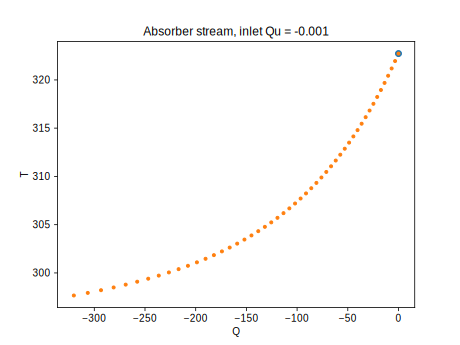

In [83]:
pltsvg()

### Trial 2.2

Just brainstorming ... As a brute-force backup, I would like to have an optimize routine that is a gradient-based method where the gradient calculation and line-search algorithms simply react to passing over the feasible boundary using exceptions instead of constraint functions. (This matters because the total UA constraint function can only be computed when the feasible heat exchange constraints are already satisfied, so in some cases it would have to return infinite values.) In other words, this would be an adaptive step size method. In pseudo-code,

In [ ]:
def optimize(fun,x0,max_iter = 100):
    x = x0.copy()
    for iter in range(max_iter):
        if step == 0:
            break
        G, H = calcGradient(fun, x)
        dx = calcLineSearch(fun, x, G, H)
        x = x + dx
        f = fun(x)
    return x, f

def calcGradient(fun, x0, max_iter = 100):
    max_iter = 100
    # Initial step sizes by component
    deltax = ones_like(x0)
    # Function values to the right
    fplus = zeros_like(x0)
    # Function values to the left
    fminus = zeros_like(x0)
    f0 = fun(x0)
    for j, _ in enumerate(deltax):
        for i in range(max_iter):
            dx = numpy.diag(deltax)[j]
            try:
                xplus = x0 + dx
                xminus = x0 - dx
                fplus[j] = fun(xplus)
                fminus[j] = fun(xminus)
                break
            except:
                deltax[j] *= 0.5
    grad, hess = calcGradHelper(f0, deltax, fplus, fminus) # TODO
    return grad, hess

def calcLineSearch(fun, x0, G, H):
    max_iter = 100
    step = 0
    direction = lshelper1(x0, G, H)
    for i in range(max_iter):
        try:
            lshelper(f
        except:
            step *= 0.5
    return step * direction

#### Aside
Furthermore, here is another related strategy. I could optimize first without the constraint on total UA. That would give me a feasible system. Then, given the desired total UA, I could have a feasible starting point by then turning down the mass flow rate using a linesearch on that parameter.

### Trial 2.3

Another idea (suggested in documention of early trials) is to do something different with the heat exchange feasibility constraints, utilizing energy imbalance. The final goal would be to allow UA values as inputs, and optimize the cooling capacity, as intended. An intermediate goal may be to simply demonstrate a solver with UA values as inputs (using some optimization routine to determine the temperature points that achieve the specified UA values).

# Scratch work

In [15]:
a=5
for i in range(9999):
    a*=0.5
    if a==0:
        break
i,a

(1076, 0.0)

In [25]:
gradient_step = numpy.array([1.,2.,3.,4.])
for j, _ in enumerate(gradient_step):
    for i in range(2):
        gradient_step[j] *= 0.5
gradient_step

array([ 0.25,  0.5 ,  0.75,  1.  ])

In [30]:
numpy.diag(gradient_step)[3]

array([ 0.,  0.,  0.,  1.])

In [50]:
%%html
<pre id="TOC-markdown">TOC will be here</pre>
<script>
$("#TOC-markdown").html(
    $('h1,h2,h3,h4').map(function(){return "  ".repeat($(this).prop("tagName")[1]) + "- ["+$(this).text()+"](" + $(this).children().attr("href") + ")";}).get().join("\n")
    );
</script>